<a href="https://colab.research.google.com/github/nemoware/suk/blob/master/appeal_outlier_detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Appeal outlier detection & experiments

In [ ]:
!nvidia-smi

Tue Nov  3 02:14:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu
!pip install --upgrade grpcio
!pip install tqdm
!pip install bert-for-tf2
!pip install sentencepiece

from google.colab import output
output.clear()

In [ ]:
import os
import math
import datetime


import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# NEW_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
# sns.set_palette(sns.color_palette(NEW_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
# import tqdm as m_tqdm
from tqdm import tqdm
# # quietly deep-reload tqdm
# import sys
# from IPython.lib import deepreload 

# # stdout = sys.stdout
# # sys.stdout = open('junk','w')
# deepreload.reload(m_tqdm)
# # sys.stdout = stdout

# output.clear()

# m_tqdm.__version__

## Init model

In [ ]:
max_seq_len = 512
model_name = "multi_cased_L-12_H-768_A-12"
model_dir = bert.fetch_google_bert_model(model_name, ".models")
model_ckpt = os.path.join(model_dir, "bert_model.ckpt")

# classes = ['Трудовое право', 'Интеллектуальная собственность, ИТ, цифровые права', 'Коммерческие операции и поставки', 'Закупки (юридические вопросы)', 'Перевозки и хранение', 'Международные санкции', 'Экологическое право', 'Налоговое право', 'Антимонопольное, тарифное регулирование', 'Строительство, недвижимость и промышленная безопасность', 'Таможенное, валютное регулирование', 'Недропользование (поиск, оценка месторождений УВС, разведка и добыча)']
classes = ['Антимонопольное, тарифное регулирование',
 'Коммерческие операции и поставки',
 'Экологическое право',
 'Налоговое право',
 'Закупки (юридические вопросы)',
 'Таможенное, валютное регулирование',
 'Строительство, недвижимость и промышленная безопасность',
 'Недропользование (поиск, оценка месторождений УВС, разведка и добыча)',
 'Трудовое право',
 'Интеллектуальная собственность, ИТ, цифровые права',
 'Перевозки и хранение',
 'Международные санкции']

print(f"classes: {len(classes)}")

multi_cased_L-12_H-768_A-12.zip: 663MB [00:04, 156MB/s]                            


extracting to: .models/multi_cased_L-12_H-768_A-12
classes: 12


In [ ]:
# tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

do_lower_case = not (model_name.find("cased") == 0 or model_name.find("multi_cased") == 0)
bert.bert_tokenization.validate_case_matches_checkpoint(do_lower_case, model_ckpt)
vocab_file = os.path.join(model_dir, "vocab.txt")
print(f'Do lower case: {do_lower_case}')
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

Do lower case: False


In [ ]:
import params_flow as pf


def create_model(max_seq_len, model_dir, model_ckpt, freeze=True, adapter_size=4):
  bert_params = bert.params_from_pretrained_ckpt(model_dir)
  print(f'bert params: {bert_params}')
  bert_params.adapter_size = adapter_size
  bert_params.adapter_init_scale = 1e-5
  l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = l_bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(name='dense_sin', units=768, activation=tf.math.sin)(cls_out)
  # logits = keras.layers.Dense(name='dense_tanh', units=768, activation="tanh")(cls_out)
  # logits = keras.layers.Dense(name='dense_relu', units=256, activation="relu")(cls_out)
  # logits = keras.layers.Dense(name='dense_gelu', units=256, activation="gelu")(cls_out)
  logits = keras.layers.BatchNormalization()(logits)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(name='initial_predictions', units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))
  
  model.summary()
  if freeze:
    l_bert.apply_adapter_freeze()
    l_bert.embeddings_layer.trainable=False 
    model.summary()

  # Дополнительная инфа https://arxiv.org/abs/1902.00751
  # apply global regularization on all trainable dense layers
  pf.utils.add_dense_layer_loss(model,
                                kernel_regularizer=keras.regularizers.l2(0.01),
                                bias_regularizer=keras.regularizers.l2(0.01))

  model.compile(optimizer=pf.optimizers.RAdam(),
                # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # c логитами почему-то не работает совсем
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
  
  
  bert.load_stock_weights(l_bert, model_ckpt)
  # bert.load_bert_weights(l_bert, model_ckpt)  

  return model

In [ ]:
model = create_model(max_seq_len, model_dir, model_ckpt, adapter_size=6)

bert params: {'initializer_range': 0.02, 'max_position_embeddings': 512, 'hidden_size': 768, 'embedding_size': None, 'project_embeddings_with_bias': True, 'vocab_size': 119547, 'use_token_type': True, 'use_position_embeddings': True, 'token_type_vocab_size': 2, 'hidden_dropout': 0.1, 'extra_tokens_vocab_size': None, 'project_position_embeddings': True, 'mask_zero': False, 'adapter_size': None, 'adapter_activation': 'gelu', 'adapter_init_scale': 0.001, 'num_heads': 12, 'size_per_head': None, 'query_activation': None, 'key_activation': None, 'value_activation': None, 'attention_dropout': 0.1, 'negative_infinity': -10000.0, 'intermediate_size': 3072, 'intermediate_activation': 'gelu', 'num_layers': 12, 'out_layer_ndxs': None, 'shared_layer': False}
bert shape (None, 512, 768)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 512)]             0      

## Load pretrained weights

In [ ]:
model_gdrive_url = 'https://drive.google.com/file/d/1TNXKem6OWWUzPmi5kDahBK0sj0N51o9J/view?usp=sharing'
model_gdrive_url_new = 'https://drive.google.com/file/d/1MvdYgdn3IOgontIG0rdG8CVFpOV82VX8/view?usp=sharing'
!gdown --id 1MvdYgdn3IOgontIG0rdG8CVFpOV82VX8 --output final.h5 

Downloading...
From: https://drive.google.com/uc?id=1MvdYgdn3IOgontIG0rdG8CVFpOV82VX8
To: /content/final.h5
720MB [00:09, 79.4MB/s]


In [ ]:
model.load_weights('final.h5')

## Classification check

In [ ]:
def get_token_ids_old(tokenizer, sentences):
  pred_tokens = map(tokenizer.tokenize, sentences)
  # print(pred_tokens)
  pred_tokens = map(lambda tok: ["[CLS]"] + tok[:min(len(tok), max_seq_len-2)] + ["[SEP]"], pred_tokens)
  pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
    
  # pad
  pred_token_ids = map(lambda tids: tids +[0]*(max_seq_len-len(tids)),pred_token_ids)
  # pred_token_ids = np.array(list(pred_token_ids))
  pred_token_ids = list(pred_token_ids)
  return pred_token_ids

def get_token_ids_faster(tokenizer, sentences, max_seq_len=512):
  pred_token_ids = []
  for sent in sentences:
    tokens = tokenizer.tokenize(sent)
    tokens = ["[CLS]"] + tokens[:min(len(tokens), max_seq_len-2)] + ["[SEP]"]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    #pad
    token_ids = token_ids +[0]*(max_seq_len-len(token_ids))
    pred_token_ids.append(token_ids)
  return pred_token_ids

def get_token_ids(tokenizer, sentences):
  return get_token_ids_faster(tokenizer, sentences, max_seq_len = max_seq_len)


In [ ]:

sentences = [
  "Требуется определить порядок возмещения вреда почве в случае выявления разливов нефти при првоедении очередной плановой проверки РПН, Акт составлен, предписание выдано. Не обжаловано",
  "На основании ст.193 ТК РФ дисциплинарное взыскание применяется не позднее одного месяца со дня обнаружения проступка. С персональными нарушениями (проступками), когда вина конкретных людей очевидна, все понятно. Точкой отсчета будет считаться документ, фиксирующий событие (Акт нарушения, служебная записка). А что делать с Происшествиями?  Если на объекте случился пожар 01.06.  В течение 15 р.д. ведет работу комиссия по расследованию происшествий (Стандарт компании). В ходе работы комиссии производится разбирательство.  16.06. - результатом работы такой комиссии станет Акт, подписанный всеми членами. Только в этот момент становится понятно, кто персонально виновен.    Какая дата станет днем обнаружения проступка? В принципе, именно в этот момент хотелось бы начинать процесс применения дисциплинарного взыскания. Насколько это законно?   Или 15 р.д. работы комиссии, должны войти в озвученный ранее период в 1 месяц?"
]
pred_token_ids = get_token_ids(tokenizer, sentences)
print(len(pred_token_ids))
probabilities = model.predict(pred_token_ids)
predictions = probabilities.argmax(axis=-1)
print(predictions)
print(probabilities)
for text, label, probs in zip(sentences, predictions, probabilities):
  print(f"text: {text}\ncategory: {classes[label]} prob: {probs[label]}")

2
[2 8]
[[1.8707500e-04 1.0077124e-05 9.9090791e-01 1.2191791e-04 5.3851577e-06
  3.5680761e-04 2.7721713e-04 7.9449732e-03 5.0146893e-05 1.3538485e-06
  5.6262095e-05 8.0879625e-05]
 [7.7295927e-06 7.5108460e-07 1.5167371e-05 1.1363016e-06 2.5240350e-05
  2.3668244e-06 2.6685067e-05 1.8369909e-05 9.9987793e-01 6.2158733e-06
  9.8672735e-06 8.4699122e-06]]
text: Требуется определить порядок возмещения вреда почве в случае выявления разливов нефти при првоедении очередной плановой проверки РПН, Акт составлен, предписание выдано. Не обжаловано
category: Экологическое право prob: 0.9909079074859619
text: На основании ст.193 ТК РФ дисциплинарное взыскание применяется не позднее одного месяца со дня обнаружения проступка. С персональными нарушениями (проступками), когда вина конкретных людей очевидна, все понятно. Точкой отсчета будет считаться документ, фиксирующий событие (Акт нарушения, служебная записка). А что делать с Происшествиями?  Если на объекте случился пожар 01.06.  В течение 1

# Embeddings model

In [ ]:
from tensorflow.keras.models import Model
layer_name = 'lambda'
embedding_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


pred_token_ids = get_token_ids(tokenizer, sentences)
embeddings = embedding_model.predict(pred_token_ids)
print(embeddings.shape)
print(embeddings)



(2, 768)
[[ 0.44444847  0.3781792   0.13738635 ... -0.60997987 -0.36317873
  -0.01152086]
 [ 0.38106343  0.52641255  0.20492157 ... -0.8632654  -0.08808331
   0.06415342]]


# Load & prepare excel

In [ ]:
url = 'https://drive.google.com/file/d/1cVO8KUNUwXgpqVxuRMUeCNwpdmd89Dlp/view?usp=sharing' 
url_new = 'https://drive.google.com/file/d/1QxfTHsFW2u12_e0AKCg_oeaJqY-ydgD2/view?usp=sharing'
!gdown --id 1QxfTHsFW2u12_e0AKCg_oeaJqY-ydgD2 --output appeal.xlsx 

Downloading...
From: https://drive.google.com/uc?id=1QxfTHsFW2u12_e0AKCg_oeaJqY-ydgD2
To: /content/appeal.xlsx
100% 1.07M/1.07M [00:00<00:00, 71.2MB/s]


In [ ]:
import pandas as pd

# offers_path = '/content/drive/My Drive/files/nemoware/СЮК/База обращений 2019-2020.xlsx'
appeal_path = 'appeal.xlsx'

# df = pd.read_excel(offers_path, sheet_name=1, index_col='Номер обращения') 
df = pd.read_excel(appeal_path, sheet_name=0, index_col='ID') 
df = df[['Тема', 'Текст обращения']]
# sorting by goal 
# df.sort_values('Номер обращения', inplace = True) 


df[df.index.duplicated()]


,Тема,Текст обращения
ID,,


##Duplicates

In [ ]:
# dropping ALL duplicte values 
df.drop_duplicates(subset = 'Текст обращения', keep = False, inplace = True) 

df[df.index.duplicated()]

,Тема,Текст обращения
ID,,


In [ ]:
df[pd.isnull(df).any(axis=1)]

,Тема,Текст обращения
ID,,


In [ ]:
df = df.dropna()
df

,Тема,Текст обращения
ID,,
0,Трудовое право,На основании ст.193 ТК РФ дисциплинарное взыск...
1,Экологическое право,Требуется определить порядок возмещения вреда ...
2,Трудовое право,помочь с определением значения формулировки п...
3,Трудовое право,ВОПРОС по графику работы сотрудника вышедшего ...
4,Международные санкции,Включен ли А.В.Дюков в санкционные списки США ...
...,...,...
2524,Налоговое право,В соответствии с п. 3-1 ст. 2 закона Томской о...
2525,Налоговое право,Просьба дать консультацию по вопросу получения...
2526,Налоговое право,порядок оформления и оплаты служебной поездки ...


##Stop phrases

In [ ]:
import re
clean_re = re.compile(
    r"("
    r"День добрый|Доброго дня|Доброе утро|Добрый вечер|Добрый день|Здравствуйте|Сориентируйте пжл|Есть вопрос|Вопрос носит срочный характер|скажите"
    r"|прошу\s+(Вас дать ответы по следующей ситуации|дать разъяснения|подсказать|помочь разобраться с вопросом|пояснить|проконсультировать|разъяснить|распределить|уточнить)"
    r"|Большая\s+просьба\s+помочь|Большое\s+спасибо|Будем\s+крайне\s+признательны"
    r"|(Скажите|Сориентируйте)[,]?\s+пожалуйста|Такой\s+вопрос"
    r"|Буду\s+благодарна\s+за\s+оказанную\s+помощь|в\s+настоящее\s+время\s+я|Заранее благодарна|Заранее спасибо"
    r"|Вводная|Вкратце\s+суть\s+дела|Возникли\s+следующие\s+вопросы|Как быть в данной ситуации|(коротко\s)?опишу суть проблемы"
    r"|Дайте\s+консультацию|дайте\+разъяснения|Надеюсь на понимание|Надеюсь на вашу помощь|Необходима ваша консультация|Требуется ваша помощь"
    r"|Уточните|Проконсультируйте|Подскажите|Пожалуйста|Хотели\s+уточнить|Хотели\s+бы\s+уточнить"
    r"|Возможно\s+ли|Тема\s+сообщения|В настоящее время"
    r"|Привет|Уважаемые\s+коллеги|Прошу\s+уточнить|Прошу\s+согласовать"
    r"|Прошу|Просьба дать|пож-та|спасибо|СпаИбо|Коллеги|Просим\s+Вас|Тема\:"
    r")[,\!\.\:]?", re.IGNORECASE)

# df['tlen']=-1
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
  text = row['Текст обращения']
  text = clean_re.sub(' ', text)
  text = text.strip(';,.!? ')
  df.at[i,'Текст обращения'] = text


100%|██████████| 2507/2507 [00:02<00:00, 991.88it/s] 


In [ ]:
df.loc[df['Тема'] == '-']

,Тема,Текст обращения
ID,,


In [ ]:
df.loc[df['Текст обращения'].isnull()]

,Тема,Текст обращения
ID,,


In [ ]:
df.loc[df['Текст обращения']=='']

,Тема,Текст обращения
ID,,


In [ ]:
df = df[df['Текст обращения']!='']

In [ ]:
# df.drop([2357,2682], inplace=True)

In [ ]:
# Row: 2102	Закупки (юридические вопросы)	"п.8.1 и п.9.1"
# df.drop([2102], inplace=True)	

In [ ]:

normal_df = df[df['Тема']!='Прочее']
normal_df = normal_df.groupby("Тема").filter(lambda x: len(x) > 15)
normal_df

,Тема,Текст обращения
ID,,
0,Трудовое право,На основании ст.193 ТК РФ дисциплинарное взыск...
1,Экологическое право,Требуется определить порядок возмещения вреда ...
2,Трудовое право,помочь с определением значения формулировки пр...
3,Трудовое право,ВОПРОС по графику работы сотрудника вышедшего ...
4,Международные санкции,Включен ли А.В.Дюков в санкционные списки США ...
...,...,...
2524,Налоговое право,В соответствии с п. 3-1 ст. 2 закона Томской о...
2525,Налоговое право,консультацию по вопросу получения свидетельств...
2526,Налоговое право,порядок оформления и оплаты служебной поездки ...


In [ ]:
pd.__version__

'1.1.3'

# Embeddings

In [ ]:
def get_embeddings(embedding_model, tokenizer, vals):
  token_ids = get_token_ids(tokenizer, vals)
  return embedding_model.predict(token_ids)


In [ ]:
%%time
normal_vals = normal_df['Текст обращения'].tolist()
normal_embeddings = get_embeddings(embedding_model, tokenizer, normal_vals)
# normal_token_ids = get_token_ids(tokenizer, normal_vals)
# normal_embeddings = embedding_model.predict(normal_token_ids)
normal_embeddings.shape


CPU times: user 22.2 s, sys: 3.87 s, total: 26 s
Wall time: 1min 44s


# Outlier detection model

## Model

In [ ]:
def create_outlier_model(input_dim, encoding_dim = 256, hidden_dim = 128):
  input_layer = keras.layers.Input(shape=(input_dim, ), name='input_embeddings')
  
  encoder = keras.layers.Dense(input_dim, activation=tf.math.sin, activity_regularizer=keras.regularizers.l1(10e-5))(input_layer)
  # encoder = keras.layers.BatchNormalization()(encoder)
  encoder = keras.layers.Dropout(0.5)(encoder)
  encoder = keras.layers.Dense(encoding_dim, activation=tf.math.sin)(encoder)
  # encoder = keras.layers.BatchNormalization()(encoder)
  encoder = keras.layers.Dropout(0.5)(encoder)
  
  
  decoder = keras.layers.Dense(hidden_dim, activation=tf.math.sin)(encoder)
  # decoder = keras.layers.Dropout(0.5)(decoder)


  # decoder = keras.layers.Dense(hidden_dim, activation=tf.math.sin)(decoder)
  # decoder = keras.layers.BatchNormalization()(decoder)

  decoder = keras.layers.Dense(encoding_dim, activation=tf.math.sin)(decoder)
  # decoder = keras.layers.Dropout(0.5)(decoder)
  # decoder = keras.layers.BatchNormalization()(decoder)
  decoder = keras.layers.Dense(input_dim, activation=tf.math.sin)(decoder)
  
  autoencoder = Model(inputs=input_layer, outputs=decoder)
  # autoencoder.build(input_shape=(None, input_dim))

  autoencoder.summary()

  mae = keras.losses.MeanAbsoluteError()
  adam = keras.optimizers.Adam(learning_rate=0.002)
  autoencoder.compile(
              # optimizer=pf.optimizers.RAdam(),
              optimizer=adam,
              loss='mse',
              # loss = mae,
              metrics=['accuracy'])

  return autoencoder

# outlier_model = create_outlier_model(normal_embeddings.shape[1], encoding_dim=700, hidden_dim=128)
outlier_model = create_outlier_model(normal_embeddings.shape[1], encoding_dim=768, hidden_dim=256)


Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embeddings (InputLayer [(None, 768)]             0         
_________________________________________________________________
dense_45 (Dense)             (None, 768)               590592    
_________________________________________________________________
dropout_23 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 768)               590592    
_________________________________________________________________
dropout_24 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               196864    
_________________________________________________________________
dense_48 (Dense)             (None, 768)             

## Fit

In [ ]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard
# from tensorflow_addons.callbacks import TQDMProgressBar 
import datetime

nb_epoch = 1000
batch_size = 256
log_dir = "log/appeal_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = TensorBoard(log_dir=log_dir)

# initialize tqdm callback with default parameters
# tqdm_callback = TQDMProgressBar()

# es = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
es = EarlyStopping(patience=4, 
                   verbose=True,
                        restore_best_weights=True, 
                        monitor='loss')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, 
                                   verbose=1, mode='max', min_lr=0.0000001)
chkpt = ModelCheckpoint(filepath=f'best_model_{datetime.datetime.now():%Y-%m-%d}'+'-{epoch:02d}-{val_loss:.2f}.h5', 
                        save_best_only=True, 
                        save_weights_only=True,
                        verbose=1
                        )

history = outlier_model.fit(
                    normal_embeddings, normal_embeddings,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[
                              #  chkpt,
                              reduce_lr, 
                               es,
                               tensorboard_callback, 
                               ])

Epoch 1/1000
8/8 [==============================] - 0s 28ms/step - loss: 0.1856 - accuracy: 0.0405 - val_loss: 0.1125 - val_accuracy: 0.1262
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0999 - accuracy: 0.1474 - val_loss: 0.0799 - val_accuracy: 0.1699
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0705 - accuracy: 0.2046 - val_loss: 0.0605 - val_accuracy: 0.2476
Epoch 4/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0569 - accuracy: 0.2565 - val_loss: 0.0497 - val_accuracy: 0.3835
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0491 - accuracy: 0.2943 - val_loss: 0.0447 - val_accuracy: 0.3301
Epoch 6/1000
1/8 [==>...........................] - ETA: 0s - loss: 0.0455 - accuracy: 0.2617
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
8/8 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.3110 - val_loss: 0.0402 - val_accuracy: 0.49

In [ ]:
import os
import glob
files = glob.glob('best_model_*.h5')
files = sorted(files,key=os.path.getmtime)
for filePath in files[1:]:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

In [ ]:
epoch, loss = len(history.history['loss']),history.history['loss'][-1]
print(f"{epoch} : {loss}")

31 : 0.036000195890665054


In [ ]:
outlier_model.save_weights(f'outlier_best_model_{datetime.datetime.now():%Y-%m-%d}-{epoch:02d}-{loss:.3f}.h5')

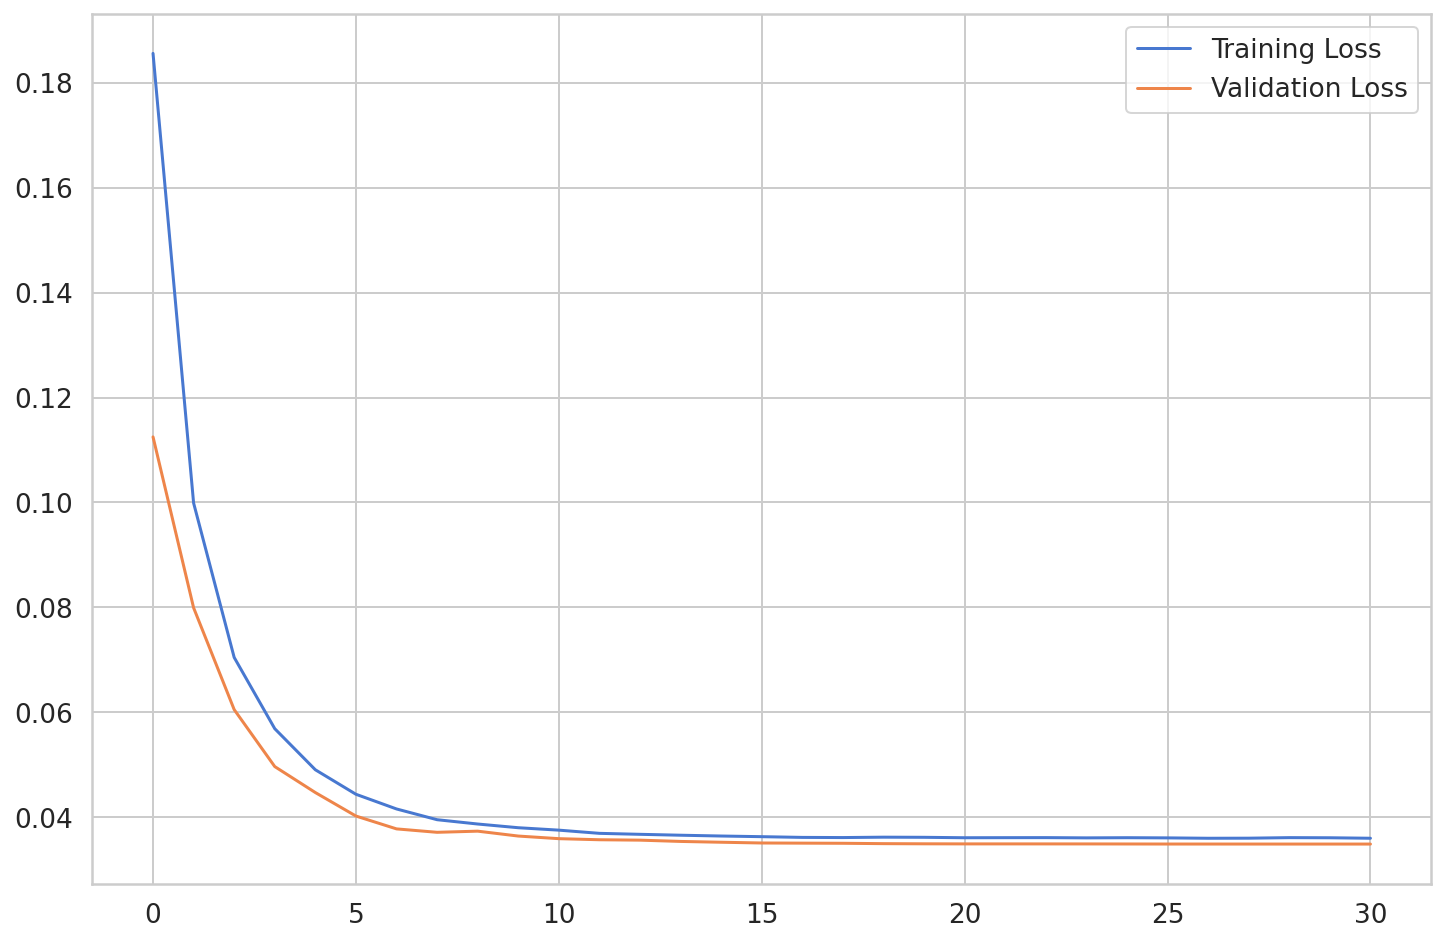

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Train MAE loss

In [ ]:
def calculte_reconstruction_error(outlier_model, embeddings):
  embeddings_pred = outlier_model.predict(embeddings)

  mse = np.mean(np.power(embeddings - embeddings_pred, 2), axis=1)
  mae = np.mean(np.abs(embeddings_pred - embeddings), axis=1)
  return (mse, mae) 


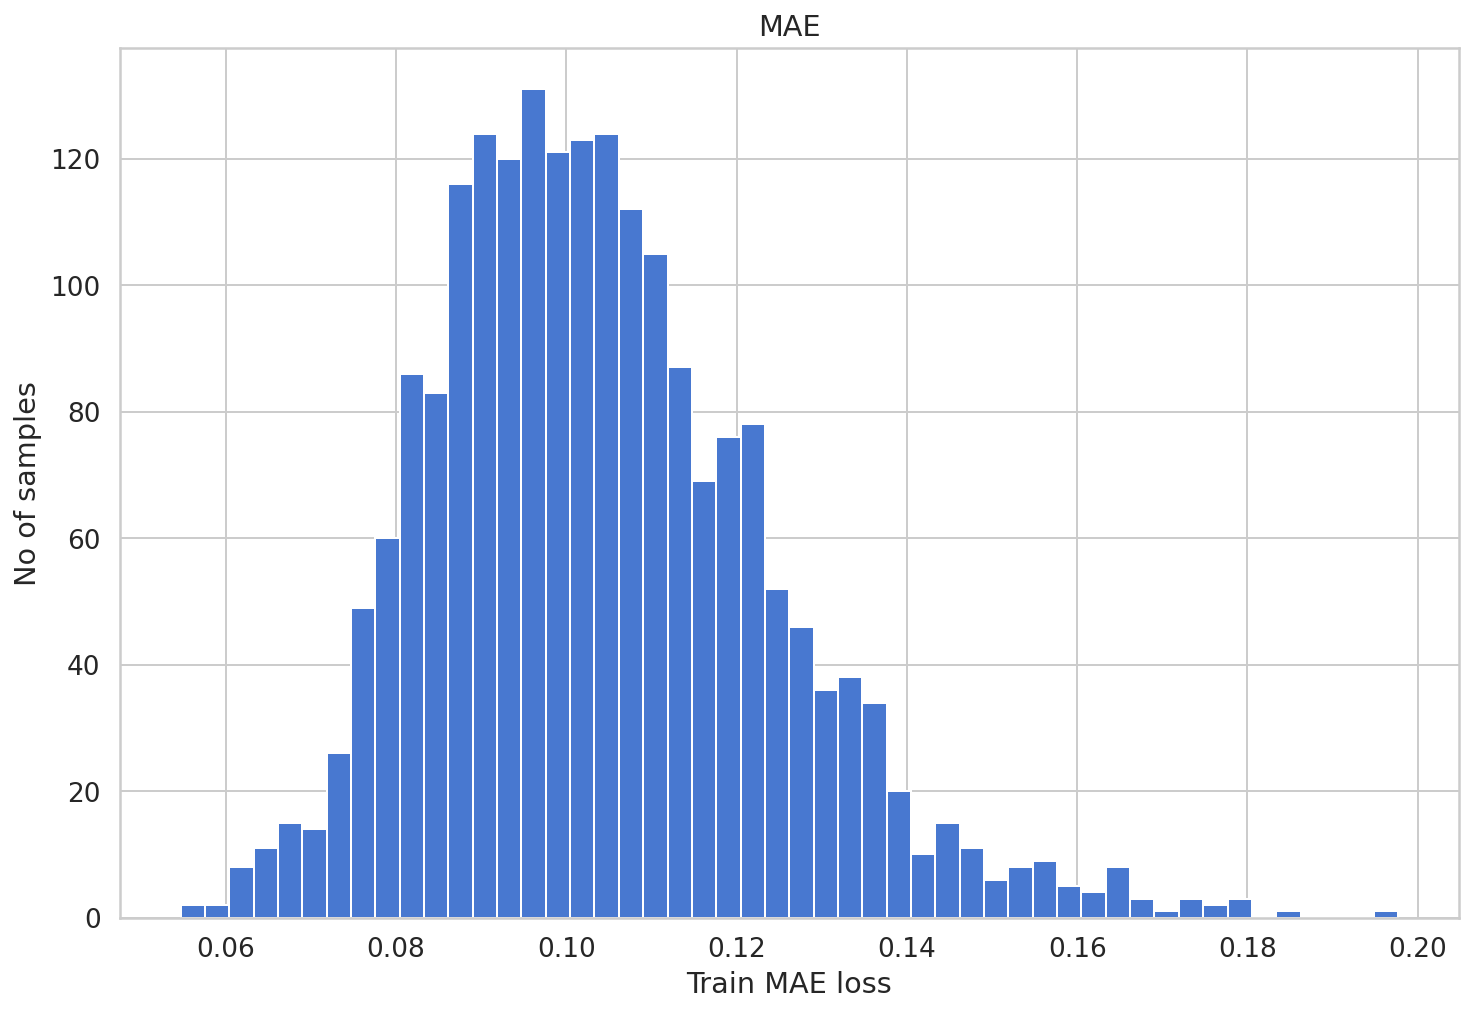

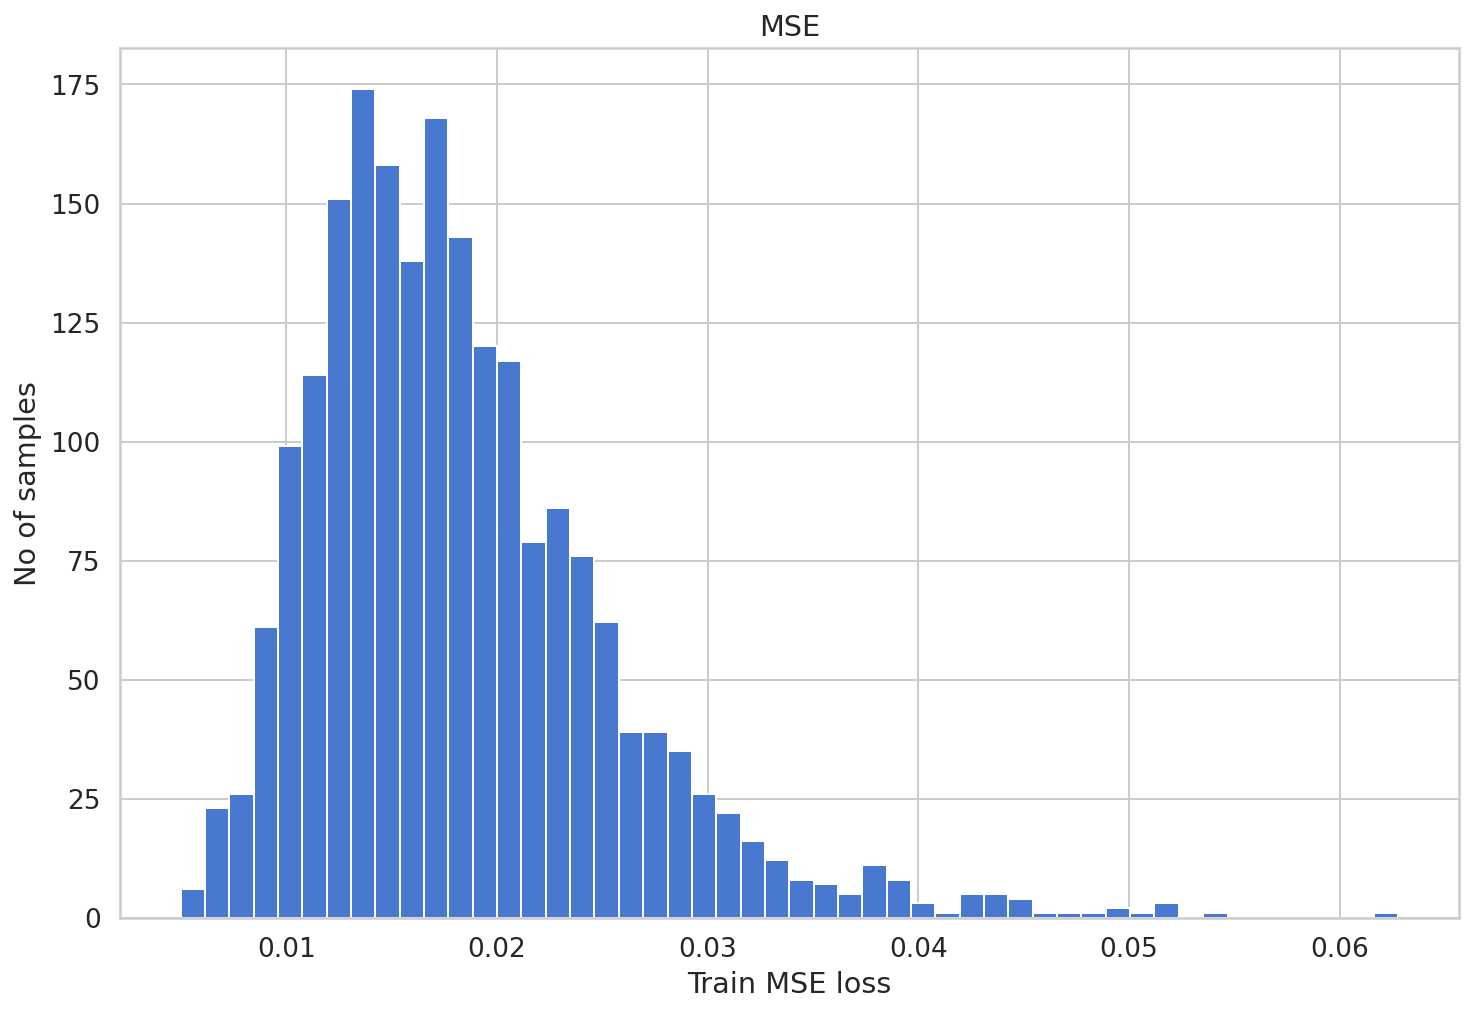

Reconstruction MAE threshold:  0.19768298
Reconstruction MSE threshold:  0.06277587


In [ ]:
# Get train MAE loss.
# normal_embeddings_pred = outlier_model.predict(normal_embeddings)
# train_mae_loss = np.mean(np.abs(normal_embeddings_pred - normal_embeddings), axis=1)
# train_mse_loss = np.mean(np.power(normal_embeddings_pred - normal_embeddings, 2), axis=1)

train_mse_loss, train_mae_loss = calculte_reconstruction_error(outlier_model, normal_embeddings)

plt.hist(train_mae_loss, bins=50)
plt.title('MAE')
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(train_mse_loss, bins=50)
plt.title('MSE')
plt.xlabel("Train MSE loss")
plt.ylabel("No of samples")
plt.show()


# Get reconstruction loss threshold.
mae_threshold = np.max(train_mae_loss)
print("Reconstruction MAE threshold: ", mae_threshold)

mse_threshold = np.max(train_mse_loss)
print("Reconstruction MSE threshold: ", mse_threshold)

In [ ]:
normal_df['mae'] = train_mae_loss
normal_df['mse'] = train_mse_loss
normal_df

,Тема,Текст обращения,mae,mse
ID,,,,
0,Трудовое право,На основании ст.193 ТК РФ дисциплинарное взыск...,0.112473,0.021257
1,Экологическое право,Требуется определить порядок возмещения вреда ...,0.174499,0.049089
2,Трудовое право,помочь с определением значения формулировки пр...,0.104217,0.019356
3,Трудовое право,ВОПРОС по графику работы сотрудника вышедшего ...,0.090837,0.014082
4,Международные санкции,Включен ли А.В.Дюков в санкционные списки США ...,0.128610,0.029844
...,...,...,...,...
2524,Налоговое право,В соответствии с п. 3-1 ст. 2 закона Томской о...,0.104359,0.018034
2525,Налоговое право,консультацию по вопросу получения свидетельств...,0.104975,0.017695
2526,Налоговое право,порядок оформления и оплаты служебной поездки ...,0.119945,0.023494


In [ ]:
x_df = normal_df[normal_df['mse']>0.05]
x_df.head(50)

,Тема,Текст обращения,mae,mse
ID,,,,
12,"Строительство, недвижимость и промышленная без...",Каким документом регламентируется квалификация...,0.197683,0.062776
849,Трудовое право,В районах РКС существуют различные размеры рай...,0.177424,0.051680
1017,Трудовое право,В феврале 2020г. поступил приказ во исполнении...,0.185902,0.054514
1587,Трудовое право,Каким законодательным документом регламентируе...,0.178687,0.052124
2436,"Таможенное, валютное регулирование",В настоящий момент прорабатывается возможность...,0.178487,0.050712
2469,"Антимонопольное, тарифное регулирование",Просим согласовать правовую позицию относител...,0.177960,0.051912


In [ ]:
x_df['Текст обращения'].tolist()

['Требуется определить порядок возмещения вреда почве в случае выявления разливов нефти при првоедении очередной плановой проверки РПН, Акт составлен, предписание выдано. Не обжаловано',
 'Каким документом регламентируется квалификация машиниста судового крана на судах РФ',
 'имеем ли мы право внести изменение в должность подписанта на основании приложенных док-тов, пример дополнения с новой должностью также во вложении',
 'дать заключение о необходимости/отсутствии необходимости ведения кадрового делопроизводства на родном языке Республики Татарстан, в связи с запуском арендованных АЗС в г. Казань в октябре 2019г',
 'лицензионное соглашение для ПО Telerik Kendo UI For Angular (https://www.telerik.com/kendo-angular-ui) проходило согласование? Если да, то изменилось ли что-то с тех пор? Если существуют ограничения по использованию указанного ПО в периметре ГПН,  привести список тех ДО, где его использование не влечет рисков для компании ГПН, либо риски могут быть признаны несущественным

### Compare reconstruction

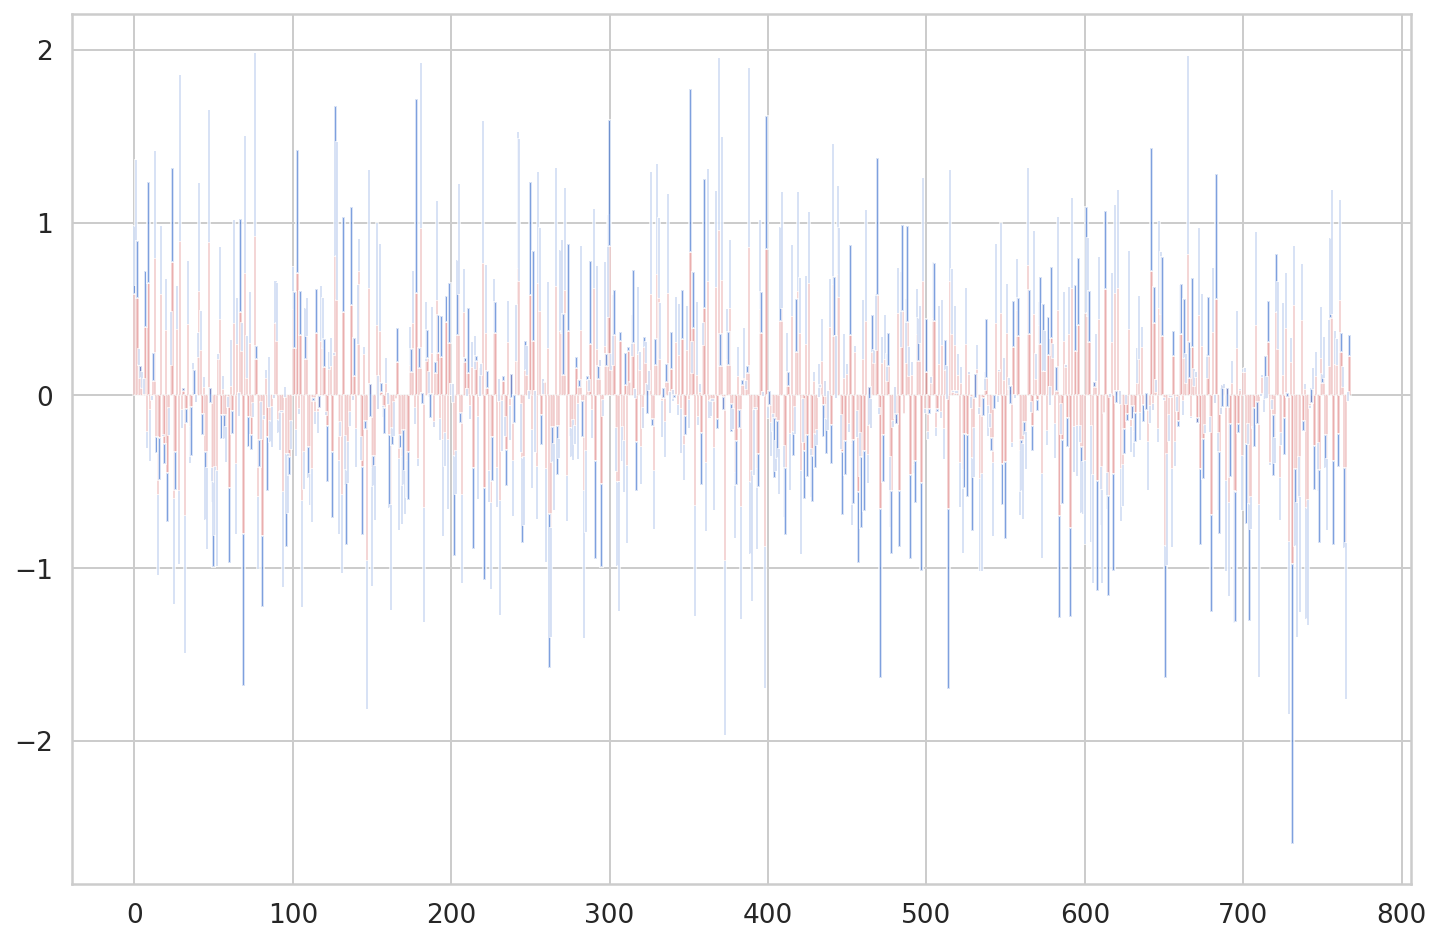

In [ ]:
normal_embeddings_pred = outlier_model.predict(normal_embeddings)
ind = np.arange(normal_embeddings.shape[1]) # the x locations for the groups
width = 1.5

plt.bar(ind, normal_embeddings_pred[0], width=width, color='r', alpha=0.5)
plt.bar(ind, normal_embeddings[0], bottom=normal_embeddings_pred[0], width=width, alpha=0.7)

plt.show()

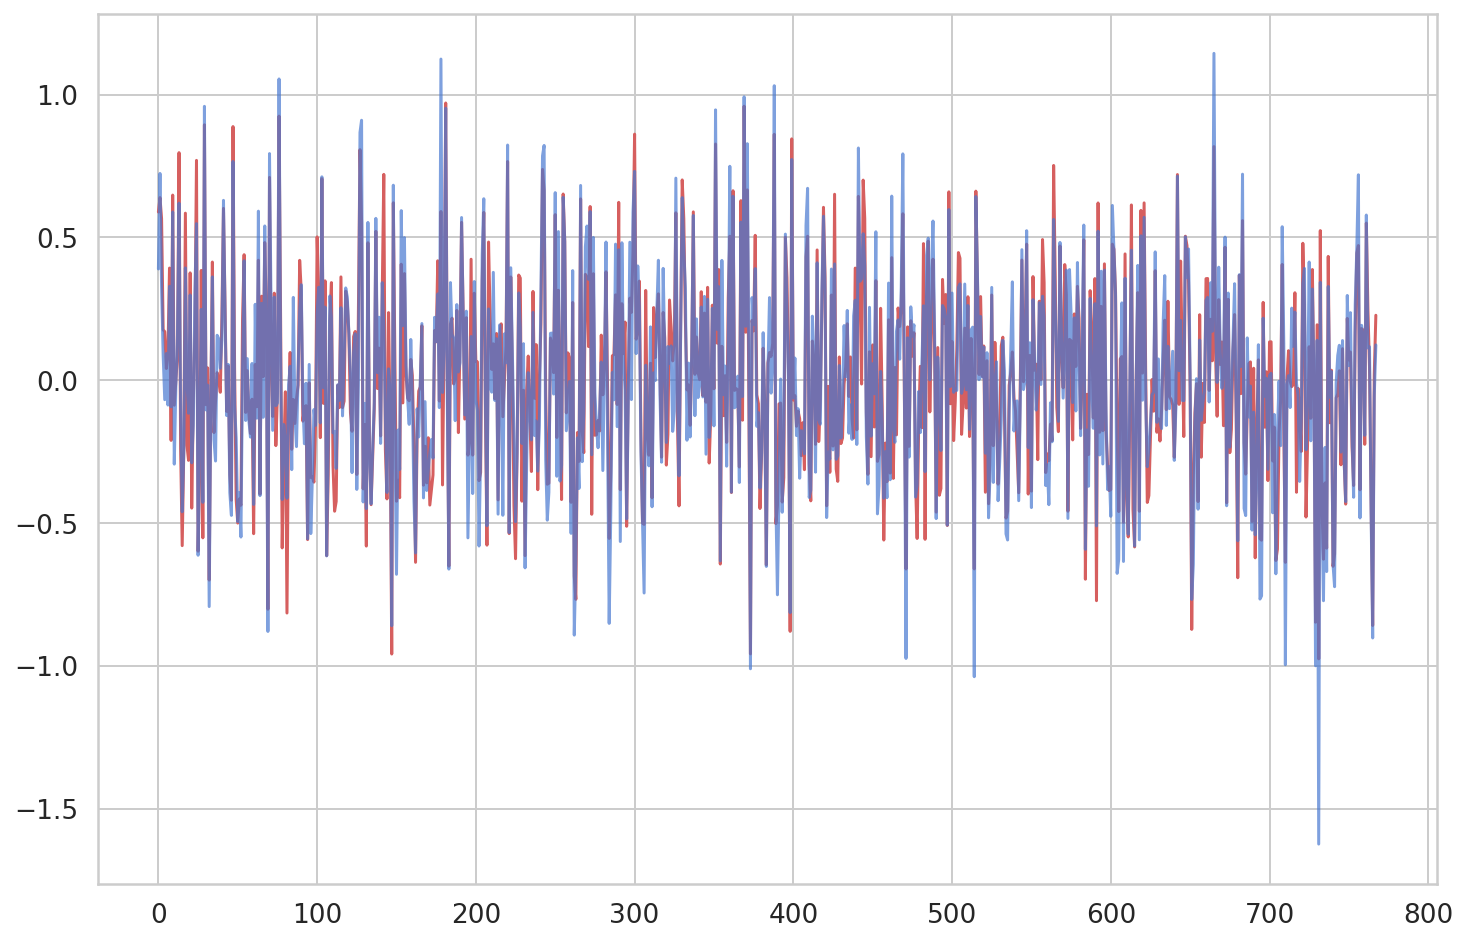

In [ ]:
# Checking how the first sequence is learnt


plt.plot(normal_embeddings_pred[0], label="reconstructed", color='r')
# plt.show()
plt.plot(normal_embeddings[0], alpha=0.7)
plt.show()

## Test outliers

In [ ]:
outlier_df = df.groupby("Тема").filter(lambda x: len(x) <= 10)
outlier_df

,Тема,Текст обращения
ID,,
47,Лицензирование недропользования,Общество с ограниченной ответственностью «Техн...
170,Лицензирование недропользования,вопрос о возможности применения штрафных санкц...
171,Привлечение финансирования и казначейские опер...,"При переходе на факторинговую схему расчета, н..."
253,Привлечение финансирования и казначейские опер...,вправе ли банк потребовать с организациипогаси...
340,Привлечение финансирования и казначейские опер...,"АО ""Газпромнефть-ОНПЗ"" находится в финальной с..."
371,Привлечение финансирования и казначейские опер...,были ли случаи отказов банков в удовлетворении...
434,Привлечение финансирования и казначейские опер...,согласовать ДД на Программно-аппаратный комплекс
1011,Лицензирование недропользования,Закон «О недрах» (далее-Закон») регулирует отн...
1014,Лицензирование недропользования,ООО «Газпромнефть-Восток» (далее - Общество) г...


In [ ]:
outlier_texts = outlier_df['Текст обращения'].tolist()
outlier_texts

['Общество с ограниченной ответственностью «Технологический центр «Бажен» (далее - ТЦ «Бажен») просит предоставить подтверждение/опровержение возможности продажи нефти, добытой из поисковой скважины. В соответствии с Производственной программой на 2020 год на Лицензионном участке «Савицкий» (Владелец лицензии- ПАО «Газпром нефть», с 2020 года лицензия будет передана дочернему ТЦ «Бажен» - ООО «Савицкий»; ТЦ «Бажен» является Оператором) планируется добыча (V ≈ 200 м3) нефти из поисково-оценочной скважины 300ПО Савицкого ЛУ на основании Лицензии ОРБ 03138 НР (далее – Лицензия) и ее последующая реализация. В связи с отсутсвием возможности хранения добытого вещества, оно планируется к реализации.\xa0\xa0Вид пользования недрами в соответствии с п.1.3. Приложения №1 к Лицензии: для геологического изучения, включающего поиски и оценку месторождений полезных ископаемых, разведки и добычи полезных ископаемых. (вид лицензии – НР). На сегодняшний день запасы на Савицком ЛУ не поставлены на баланс

In [ ]:
%%time
# outlier_token_ids = get_token_ids(tokenizer, outlier_texts)
# outlier_embeddings = embedding_model.predict(outlier_token_ids)
outlier_embeddings = get_embeddings(embedding_model, tokenizer, outlier_texts)
outlier_embeddings.shape

CPU times: user 266 ms, sys: 41.3 ms, total: 307 ms
Wall time: 855 ms


In [ ]:
# outlier_embeddings_pred = outlier_model.predict(outlier_embeddings)

# mse = np.mean(np.power(outlier_embeddings - outlier_embeddings_pred, 2), axis=1)
# mae = np.mean(np.abs(outlier_embeddings_pred - outlier_embeddings), axis=1)

mse, mae = calculte_reconstruction_error(outlier_model, outlier_embeddings)

outlier_df['mae'] = mae
outlier_df['mse'] = mse

outlier_df

,Тема,Текст обращения,mae,mse
ID,,,,
47,Лицензирование недропользования,Общество с ограниченной ответственностью «Техн...,0.106316,0.018353
170,Лицензирование недропользования,вопрос о возможности применения штрафных санкц...,0.130707,0.027206
171,Привлечение финансирования и казначейские опер...,"При переходе на факторинговую схему расчета, н...",0.116508,0.021542
253,Привлечение финансирования и казначейские опер...,вправе ли банк потребовать с организациипогаси...,0.109646,0.019335
340,Привлечение финансирования и казначейские опер...,"АО ""Газпромнефть-ОНПЗ"" находится в финальной с...",0.117234,0.021739
371,Привлечение финансирования и казначейские опер...,были ли случаи отказов банков в удовлетворении...,0.116052,0.021462
434,Привлечение финансирования и казначейские опер...,согласовать ДД на Программно-аппаратный комплекс,0.138666,0.031282
1011,Лицензирование недропользования,Закон «О недрах» (далее-Закон») регулирует отн...,0.090980,0.013452
1014,Лицензирование недропользования,ООО «Газпромнефть-Восток» (далее - Общество) г...,0.098473,0.015589


In [ ]:
fixed_mse_threshold = math.trunc(mse_threshold*100.)/100.
fixed_mae_threshold = math.trunc(mae_threshold*100.)/100.
print(f"MAE Threshold: {fixed_mae_threshold} original:{mae_threshold}")
print(f"MSE Threshold: {fixed_mse_threshold} original:{mse_threshold}")

MAE Threshold: 0.15 original:0.15886473655700684
MSE Threshold: 0.04 original:0.040074672549963


In [ ]:
fixed_mse_threshold = 0.02

outlier_df['MSE Outlier'] = False
outlier_df.loc[outlier_df['mse']>fixed_mse_threshold, 'MSE Outlier'] = True

outlier_df['MAE Outlier'] = False
outlier_df.loc[outlier_df['mae']>fixed_mae_threshold, 'MAE Outlier'] = True


outlier_df

NameError: ignored

In [ ]:
outlier_df['Текст обращения'].tolist()

# Outlier Detection VAE

In [ ]:
!pip install alibi-detect

In [ ]:
import logging

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.keras.backend.clear_session()

import alibi_detect
# print(f'alibi_detect: {alibi_detect.od.__all__}')

from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_tabular, plot_roc




n_features = normal_embeddings.shape[1]
latent_dim = 256

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(n_features,)),
      Dense(700, activation=tf.nn.relu),
      Dense(512, activation=tf.nn.relu),
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(latent_dim,)),
      Dense(512, activation=tf.nn.relu),
      Dense(700, activation=tf.nn.relu),
      Dense(n_features, activation=None)
  ])

# initialize outlier detector
od = OutlierVAE(threshold=None,  # threshold for outlier score
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=5)
# train
od.fit(normal_embeddings,
        loss_fn=elbo,
        cov_elbo=dict(sim=.01),
        epochs=30,
        verbose=True)

# save the trained outlier detector
save_detector(od, 'vae_od')


# 'Others' classification

In [ ]:
others_df = df[df['Тема']=='Прочее']
others_df

In [ ]:
others_vals = others_df['Текст обращения'].tolist()
others_vals[:10]

## Predict

In [ ]:
pred_token_ids = get_token_ids(tokenizer, others_vals)



In [ ]:
%%time
probabilities = model.predict(pred_token_ids)
pred_embeddings = embedding_model.predict(pred_token_ids)

In [ ]:
import math
names_col = ['Тема2', 'Тема1']
prob_col = ['Вероятность Темы 2', 'Вероятность Темы 1']
print(len(probabilities))
others_df['Тема1']=''
others_df['Вероятность Темы 1']=0
others_df['Тема2']=''
others_df['Вероятность Темы 2']=0

others_df

In [ ]:
mse, mae = calculte_reconstruction_error(outlier_model, pred_embeddings)

others_df['mae'] = mae
others_df['mse'] = mse

## Set to DataFrame

In [ ]:
print(f'probs len {len(probabilities)}')
print(f'{len(classes)}')

for i in tqdm(range(0, len(probabilities))):
  probs = probabilities[i]
  # print(f'{i} {others_df.iloc[i, 1]}')

  ind = np.argpartition(probs, -2)[-2:] #top-2
  ind = ind[np.argsort(probs[ind])] #sort indices
  # print(ind)

  others_df.iat[i, 2] = classes[ind[0]]
  others_df.iat[i, 3] = round(probs[ind[0]]*100., 1)

  others_df.iat[i, 4] = classes[ind[1]]
  others_df.iat[i, 5] = round(probs[ind[1]]*100., 1)

    # print(f"\tcategory: {classes[j]} prob: {probs[j]*100.:.1f}")



In [ ]:
fixed_mse_threshold = 0.02
fixed_mae_threshold = 0.14

others_df['MSE Outlier'] = False
others_df.loc[others_df['mse']>fixed_mse_threshold, 'MSE Outlier'] = True

others_df['MAE Outlier'] = False
others_df.loc[others_df['mae']>fixed_mae_threshold, 'MAE Outlier'] = True


others_df

In [ ]:

others_df

In [ ]:
others_df.to_excel("predicted.xlsx")  

In [ ]:
# !pip install pyarrow==0.15.1
# !pip install -v perspective-python